<a href="https://colab.research.google.com/github/IsinghGitHub/CellStrat/blob/master/Final_Version_Redda_Project_90__Accuracy_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression on HR Performance Data

# 1 | Library Import and Data Loading

In [179]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import metrics

## Data Cleaning & Preparation

In [180]:
""" Load in the data and examine the head. """

data = '/content/drive/MyDrive/Redda/tabular-lstm-64ec7914791a2a99c328efa3-data_preview_LSTM.csv'
df = pd.read_csv(data)
df.head(5)

,ID,COMPANY ID,JOB,Department,MBTI,Predictor 1,Predictor 2,Predictor 3,Predictor 4,CTAR,Aggregate total using predictors weights of study 2,Decision based on Study 2,Individual Performance FY22,Gender,Age,Tenure
0,AIT160,AIT,Accountant,Sales,ENTJ,64%,33%,33%,42%,0%,#REF!,Hired,74%,F,34,3
1,ABS045,ABS,Consultant,Sales,ESTJ,63%,70%,25%,33%,8%,#REF!,Hired,70%,M,42,16
2,ORA262,ORA,IT Engineer,IT,ESTJ,72%,60%,25%,33%,8%,#REF!,Hired,78%,M,33,0
3,ORA335,ORA,Marketing Assistant,IT,ISTJ,76%,-17%,-17%,-33%,-8%,#REF!,Not Hired,40%,M,23,0
4,ORA290,ORA,Marketing Assistant,Marketing,ENTP,65%,17%,0%,8%,8%,#REF!,Not Hired,60%,F,19,0


# 2 | Data preprocessing

In [181]:
df.columns


Index(['ID', 'COMPANY ID', 'JOB', 'Department', 'MBTI', 'Predictor 1',
       'Predictor 2', 'Predictor 3', 'Predictor 4', 'CTAR',
       'Aggregate total using predictors weights of study 2',
       'Decision based on Study 2', 'Individual Performance FY22', 'Gender',
       'Age', 'Tenure'],
      dtype='object')

 ### 2.1 Rename columns

In [182]:

# Rename columns
new_column_names = {
    'Decision based on Study 2': 'Decisionstd2',
    'Individual Performance FY22': 'IndividualPerf',
    'Aggregate total using predictors weights of study 2': 'AggregateTotPred',
    'Predictor 1':'Predictor1',
    'Predictor 2':'Predictor2',
    'Predictor 3':'Predictor3',
    'Predictor 4':'Predictor4'
    # Add more mappings as needed
}

df.rename(columns=new_column_names, inplace=True)

In [183]:
""" Iterate through the dataframes columns and covert to lowercase for QoL. """
low_col = []
for i in df.columns:
    i = i.lower()
    low_col.append(i)
df.columns = low_col

In [184]:
# Count null values in each column
null_counts = df.isnull().sum()

print(null_counts)

id                  0
company id          0
job                 0
department          0
mbti                7
predictor1          0
predictor2          0
predictor3          0
predictor4          0
ctar                0
aggregatetotpred    0
decisionstd2        0
individualperf      6
gender              0
age                 0
tenure              0
dtype: int64


In [185]:
# Calculate null percentages for each column
null_percentages = (df.isnull().sum() / len(df)) * 100

# Print null percentages
print("Null Percentages in Each Column:")
print(null_percentages)

Null Percentages in Each Column:
id                  0.000000
company id          0.000000
job                 0.000000
department          0.000000
mbti                0.233333
predictor1          0.000000
predictor2          0.000000
predictor3          0.000000
predictor4          0.000000
ctar                0.000000
aggregatetotpred    0.000000
decisionstd2        0.000000
individualperf      0.200000
gender              0.000000
age                 0.000000
tenure              0.000000
dtype: float64


In [186]:
df.shape


(3000, 16)

In [187]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                3000 non-null   object
 1   company id        3000 non-null   object
 2   job               3000 non-null   object
 3   department        3000 non-null   object
 4   mbti              2993 non-null   object
 5   predictor1        3000 non-null   object
 6   predictor2        3000 non-null   object
 7   predictor3        3000 non-null   object
 8   predictor4        3000 non-null   object
 9   ctar              3000 non-null   object
 10  aggregatetotpred  3000 non-null   object
 11  decisionstd2      3000 non-null   object
 12  individualperf    2994 non-null   object
 13  gender            3000 non-null   object
 14  age               3000 non-null   int64 
 15  tenure            3000 non-null   int64 
dtypes: int64(2), object(14)
memory usage: 375.1+ KB


In [188]:
""" Investigate categorical columns that seem irrelevent. """
df.department.value_counts()

IT                                979
Sales                             816
Finance                           425
Supply Chain                      339
Marketing                          97
Technical                          75
After Sales                        61
Payroll                            55
General Management                 48
Sales/IT                           36
Sales/Marketing                    30
Sales SPECIALIST CYBERSECURITE     28
Sales/Finance                       6
Human Ressources                    5
Name: department, dtype: int64

In [189]:
""" Investigate categorical columns that seem irrelevent. """

df.mbti.value_counts()

ISTJ    1016
ESTJ     991
ENTJ     273
INTJ     218
ESFJ     165
ESTP      69
ENFJ      52
ISFJ      48
ENTP      44
ISTP      33
ESFP      28
INFJ      23
ENFP      11
INTP       9
INFP       8
ISFP       5
Name: mbti, dtype: int64

## 2.2 Dealing with duplicated values

In [190]:
print('Number of duplicated values in training dataset: ', df.duplicated().sum())


Number of duplicated values in training dataset:  1651


In [191]:
df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")
print("*" * 100)


Duplicated values dropped succesfully
****************************************************************************************************


## Creating numerical and categorical lists

In [192]:
# distinction is based on the number of different values in the column
columns = list(df.columns)

categoric_columns = []
numeric_columns = []

for i in columns:
    if len(df[i].unique()) > 6:
        numeric_columns.append(i)
    else:
        categoric_columns.append(i)

categoric_columns = categoric_columns[:-1] # Excluding target:'Churn'

In [193]:
print('Numerical fetures: ',numeric_columns)
print('Categorical fetures: ',categoric_columns)

Numerical fetures:  ['id', 'job', 'department', 'mbti', 'predictor1', 'predictor2', 'predictor3', 'predictor4', 'ctar', 'individualperf', 'age', 'tenure']
Categorical fetures:  ['company id', 'aggregatetotpred', 'decisionstd2']


### We will be dropping the above columns along with some not required columns

In [194]:
columns_to_drop = ["job","company id","department"]
df = df.drop(columns=columns_to_drop)

In [195]:
df.head()

,id,mbti,predictor1,predictor2,predictor3,predictor4,ctar,aggregatetotpred,decisionstd2,individualperf,gender,age,tenure
0,AIT160,ENTJ,64%,33%,33%,42%,0%,#REF!,Hired,74%,F,34,3
1,ABS045,ESTJ,63%,70%,25%,33%,8%,#REF!,Hired,70%,M,42,16
2,ORA262,ESTJ,72%,60%,25%,33%,8%,#REF!,Hired,78%,M,33,0
3,ORA335,ISTJ,76%,-17%,-17%,-33%,-8%,#REF!,Not Hired,40%,M,23,0
4,ORA290,ENTP,65%,17%,0%,8%,8%,#REF!,Not Hired,60%,F,19,0


In [196]:
""" Apply Pandas get_dummies function to the dataframe to transform the categorical variables to numeric.
    This will create additional columns in your dataframe."""

#df_dum = pd.get_dummies(df)

' Apply Pandas get_dummies function to the dataframe to transform the categorical variables to numeric.\n    This will create additional columns in your dataframe.'

In [197]:
#df_dum

In [198]:
#df_dum

## Correlation

Find out which attribute correlates with individualperf the most.



### What are the types of the variables?

Basically we have two types of variables if we are only looking into the variable itself. We have continuous variable and categorical variable. While continuous variables can be further categorize as either interval or ratio variables, categorical variables can be further categorize as either nominal, ordinal or dichotomous.

'decisionstd2' is a dichotomous variable as it has two categories, 'Hired' and 'NotHired'.

'MBTI' is a nominal variable as it has more than two categories. ISTJ, 'ESTP', 'ESTJ.



The number in each box represents the Pearson Correlation Coefficient between the two variables.

The math behind this: It's the covariance of the two variables divided by the standard deviation of the two variables. In this method, the correlation ranges from -1 to 1, which allows us to tell how strong the relationship it is between the two variables as the bigger the absolute it is the more correlated they are, while we can't tell it from covariance. That's why the first box is 1 as 'score' is 100% correlated with 'score' itself.



Back to our questions, regarding the correlation coefficient, we can see that 'predictor2','predictor3' and 'predictor4' have the biggest positive number, 0.53,0.37, and 0.36, while 'age' is the most negative one, -0.072.

We can easily interpret it as the following: The bigger number of 'predictor' the bigger  the  'individual_performance' we find and vice versa, 'predictor' is having the most positive relationship with 'individual_performance'.

## Droping unnessesary columns based on the corr results

In [199]:
columns = ['id', 'company id', 'job', 'department', 'mbti', 'predictor1',
       'predictor2', 'predictor3', 'predictor4', 'ctar', 'aggregatetotpred',
       'decisionstd2', 'individualperf', 'gender', 'age', 'tenure', 'degree']
columns_to_drop = ['id','mbti','aggregatetotpred']

In [200]:
df.columns

Index(['id', 'mbti', 'predictor1', 'predictor2', 'predictor3', 'predictor4',
       'ctar', 'aggregatetotpred', 'decisionstd2', 'individualperf', 'gender',
       'age', 'tenure'],
      dtype='object')

In [201]:
df = df.drop(columns=columns_to_drop)
df = df.dropna()

In [202]:
df.columns

Index(['predictor1', 'predictor2', 'predictor3', 'predictor4', 'ctar',
       'decisionstd2', 'individualperf', 'gender', 'age', 'tenure'],
      dtype='object')

In [203]:
df

,predictor1,predictor2,predictor3,predictor4,ctar,decisionstd2,individualperf,gender,age,tenure
0,64%,33%,33%,42%,0%,Hired,74%,F,34,3
1,63%,70%,25%,33%,8%,Hired,70%,M,42,16
2,72%,60%,25%,33%,8%,Hired,78%,M,33,0
3,76%,-17%,-17%,-33%,-8%,Not Hired,40%,M,23,0
4,65%,17%,0%,8%,8%,Not Hired,60%,F,19,0
...,...,...,...,...,...,...,...,...,...,...
2968,49%,-13%,-17%,0%,17%,Not Hired,50%,F,31,0
2975,65%,17%,33%,-8%,0%,Not Hired,55%,M,22,0
2988,72%,27%,0%,33%,-17%,Not Hired,55%,F,40,0
2991,36%,50%,17%,25%,8%,Not Hired,70%,F,30,6


## Checking unique values in all the columns

In [204]:
#Let's check the no. of unique values in all the columns
print('Unique values:')
for i in df.columns:
    print(i,df[i].nunique())
    print()

Unique values:
predictor1 52

predictor2 45

predictor3 18

predictor4 18

ctar 17

decisionstd2 2

individualperf 50

gender 2

age 36

tenure 20



## Let's convert the columns to number

## What is encoding?

Encoding is the technique we use to convert categorical entry in a dataset to a numerical data. Let say we have a dataset of employees in which there is a column that contains the information about the city location of an employee. Now we want to use this data to form a model which could predict the salary of an employee based upon his/her other details. Obviously, this model doesn’t understand anything about the city name. So how will you make the model know about it? For example, an employee who lives in a metropolitan city earns more than employees of a small city. Someway we need to make the model know about this . Yes, the way you are thinking in your mind is what we will do through code. As obvious we are thinking to rank the city based upon some spec . These ways of converting a categorical data to a numerical data are our target.

### One-Hot Encoding


One-Hot Encoding consists on generating a Boolean column for each category for a given qualitative variable.

Limitation of One-Hot Encoding

One-hot encoding is a very popular transformation to the categorical variables. However, it increases the data dimensionality (The Curse of Dimensionality). When the qualitative variables in the dataset have many modalities, the transformation via one-hot encoding will lead to a significant increase in size. This is not desirable especially when the original dataset is already large.

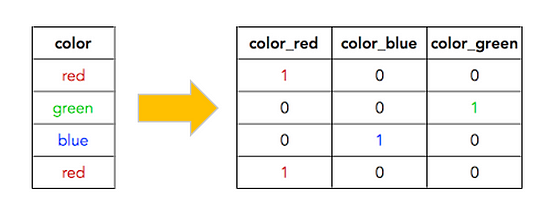Heart Disease

## One hot encoding with Pandas (get_dummies)


In [205]:
df.columns

Index(['predictor1', 'predictor2', 'predictor3', 'predictor4', 'ctar',
       'decisionstd2', 'individualperf', 'gender', 'age', 'tenure'],
      dtype='object')

In [206]:
# Create dummy variables for categorical columns
categorical_columns = [ 'gender','decisionstd2']  # List of categorical columns
data_dummies = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Print the first few rows of the dataset with dummy variables
print(data_dummies.head())

  predictor1 predictor2 predictor3 predictor4 ctar individualperf  age  \
0        64%        33%        33%        42%   0%            74%   34   
1        63%        70%        25%        33%   8%            70%   42   
2        72%        60%        25%        33%   8%            78%   33   
3        76%       -17%       -17%       -33%  -8%            40%   23   
4        65%        17%         0%         8%   8%            60%   19   

   tenure  gender_M  decisionstd2_Not Hired  
0       3         0                       0  
1      16         1                       0  
2       0         1                       0  
3       0         1                       1  
4       0         0                       1  


In [207]:
data_dummies

,predictor1,predictor2,predictor3,predictor4,ctar,individualperf,age,tenure,gender_M,decisionstd2_Not Hired
0,64%,33%,33%,42%,0%,74%,34,3,0,0
1,63%,70%,25%,33%,8%,70%,42,16,1,0
2,72%,60%,25%,33%,8%,78%,33,0,1,0
3,76%,-17%,-17%,-33%,-8%,40%,23,0,1,1
4,65%,17%,0%,8%,8%,60%,19,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2968,49%,-13%,-17%,0%,17%,50%,31,0,0,1
2975,65%,17%,33%,-8%,0%,55%,22,0,1,1
2988,72%,27%,0%,33%,-17%,55%,40,0,0,1
2991,36%,50%,17%,25%,8%,70%,30,6,0,1


## Deal with Percentage Columns

In [208]:
# List of columns containing percentage values
percentage_columns = ['predictor1',	'predictor2',	'predictor3',	'predictor4',	'ctar',	'individualperf']

# Loop through the percentage columns and convert to numerical values
for col in percentage_columns:
    data_dummies[col] = data_dummies[col].str.rstrip('%').astype(float) / 100.0

# Print the first few rows of the updated dataset
print(data_dummies.head())

   predictor1  predictor2  predictor3  predictor4  ctar  individualperf  age  \
0        0.64        0.33        0.33        0.42  0.00            0.74   34   
1        0.63        0.70        0.25        0.33  0.08            0.70   42   
2        0.72        0.60        0.25        0.33  0.08            0.78   33   
3        0.76       -0.17       -0.17       -0.33 -0.08            0.40   23   
4        0.65        0.17        0.00        0.08  0.08            0.60   19   

   tenure  gender_M  decisionstd2_Not Hired  
0       3         0                       0  
1      16         1                       0  
2       0         1                       0  
3       0         1                       1  
4       0         0                       1  


In [209]:
df_dummy = data_dummies.copy()

In [210]:
df_dummy

,predictor1,predictor2,predictor3,predictor4,ctar,individualperf,age,tenure,gender_M,decisionstd2_Not Hired
0,0.64,0.33,0.33,0.42,0.00,0.74,34,3,0,0
1,0.63,0.70,0.25,0.33,0.08,0.70,42,16,1,0
2,0.72,0.60,0.25,0.33,0.08,0.78,33,0,1,0
3,0.76,-0.17,-0.17,-0.33,-0.08,0.40,23,0,1,1
4,0.65,0.17,0.00,0.08,0.08,0.60,19,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2968,0.49,-0.13,-0.17,0.00,0.17,0.50,31,0,0,1
2975,0.65,0.17,0.33,-0.08,0.00,0.55,22,0,1,1
2988,0.72,0.27,0.00,0.33,-0.17,0.55,40,0,0,1
2991,0.36,0.50,0.17,0.25,0.08,0.70,30,6,0,1


In [211]:
# making a normalisation function

def normalize(col):
    return ((col-np.min(col)) / (np.max(col) - np.min(col)))


# applying normalize() fucntion to all columns using apply function

df_dummy = df_dummy.apply(normalize)

# Exploratory Data Analysis (EDA)

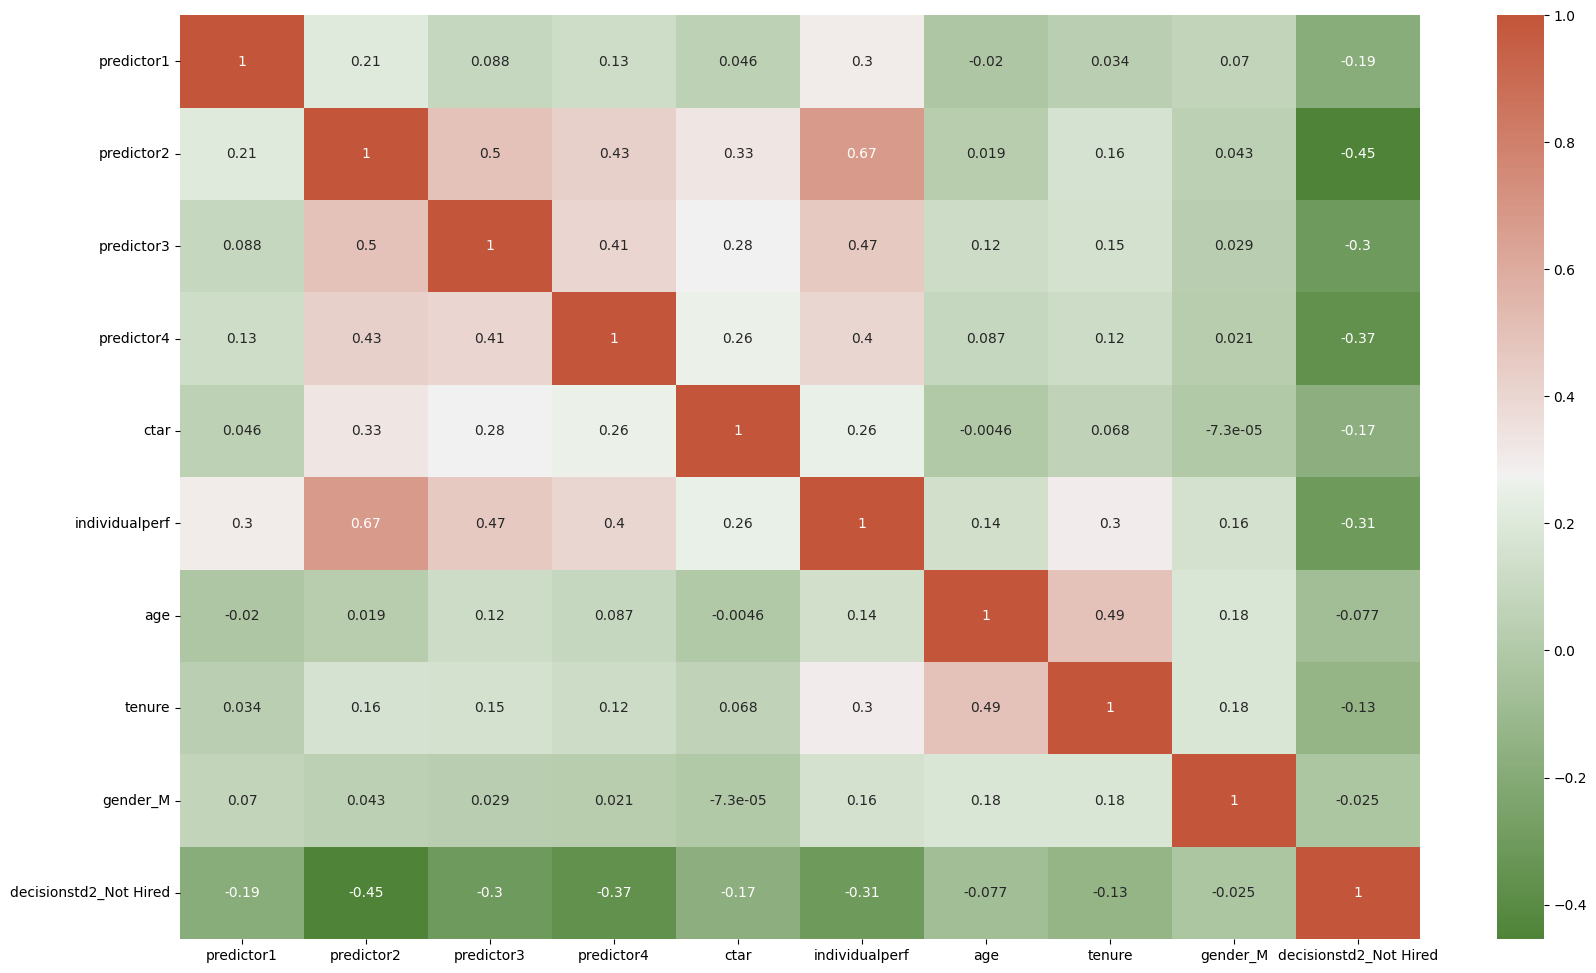

In [212]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#df_cor = df_l.iloc[:,5:]
df_cor = df_dummy
corrmat = df_cor.corr()

plt.figure(figsize=(20, 12))
p =sns.heatmap(corrmat, annot=True, cmap=sns.diverging_palette(120, 20, as_cmap=True))

# 4 | Feature Engineering

In [213]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    return R2, adjusted_r2, CV_R2, RMSE

    print('RMSE:', round(RMSE,4))
    print('R2:', round(R2,4))
    print('Adjusted R2:', round(adjusted_r2, 4) )
    print("Cross Validated R2: ", round(cv_score.mean(),4) )

In [214]:
df_dummy

,predictor1,predictor2,predictor3,predictor4,ctar,individualperf,age,tenure,gender_M,decisionstd2_Not Hired
0,0.673684,0.598802,0.773333,0.666667,0.600,0.436709,0.394737,0.15,0.0,0.0
1,0.663158,0.820359,0.720000,0.606667,0.664,0.411392,0.605263,0.80,1.0,0.0
2,0.757895,0.760479,0.720000,0.606667,0.664,0.462025,0.368421,0.00,1.0,0.0
3,0.800000,0.299401,0.440000,0.166667,0.536,0.221519,0.105263,0.00,1.0,1.0
4,0.684211,0.502994,0.553333,0.440000,0.664,0.348101,0.000000,0.00,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2968,0.515789,0.323353,0.440000,0.386667,0.736,0.284810,0.315789,0.00,0.0,1.0
2975,0.684211,0.502994,0.773333,0.333333,0.600,0.316456,0.078947,0.00,1.0,1.0
2988,0.757895,0.562874,0.553333,0.606667,0.464,0.316456,0.552632,0.00,0.0,1.0
2991,0.378947,0.700599,0.666667,0.553333,0.664,0.411392,0.289474,0.30,0.0,1.0


In [215]:
# Remove rows with null and NaN values
df_dummy = df_dummy.dropna()


In [216]:
df_dummy.shape

(1346, 10)

## Outlier Detection

## Remove the records which are above the upper bound value and records below the lower bound value!


In [217]:

from scipy import stats

# Calculate Z-scores for each column
z_scores = np.abs(stats.zscore(df_dummy))

# Define a threshold for Z-score above which a data point is considered an outlier
z_threshold = 3

# Identify rows with outlier values
outliers = np.where(z_scores > z_threshold)



# Remove rows containing outliers
df_cleaned = df_dummy[(z_scores < z_threshold).all(axis=1)]

print("Original DataFrame:")
print(df_dummy)

print("\nCleaned DataFrame (outliers removed):")
print(df_cleaned)

Original DataFrame:
      predictor1  predictor2  predictor3  predictor4   ctar  individualperf  \
0       0.673684    0.598802    0.773333    0.666667  0.600        0.436709   
1       0.663158    0.820359    0.720000    0.606667  0.664        0.411392   
2       0.757895    0.760479    0.720000    0.606667  0.664        0.462025   
3       0.800000    0.299401    0.440000    0.166667  0.536        0.221519   
4       0.684211    0.502994    0.553333    0.440000  0.664        0.348101   
...          ...         ...         ...         ...    ...             ...   
2968    0.515789    0.323353    0.440000    0.386667  0.736        0.284810   
2975    0.684211    0.502994    0.773333    0.333333  0.600        0.316456   
2988    0.757895    0.562874    0.553333    0.606667  0.464        0.316456   
2991    0.378947    0.700599    0.666667    0.553333  0.664        0.411392   
2992    0.400000    0.640719    0.666667    0.553333  0.664        0.348101   

           age  tenure  gender_

## Train and Test Data


In [218]:
df_cleaned

,predictor1,predictor2,predictor3,predictor4,ctar,individualperf,age,tenure,gender_M,decisionstd2_Not Hired
0,0.673684,0.598802,0.773333,0.666667,0.600,0.436709,0.394737,0.15,0.0,0.0
2,0.757895,0.760479,0.720000,0.606667,0.664,0.462025,0.368421,0.00,1.0,0.0
3,0.800000,0.299401,0.440000,0.166667,0.536,0.221519,0.105263,0.00,1.0,1.0
4,0.684211,0.502994,0.553333,0.440000,0.664,0.348101,0.000000,0.00,0.0,1.0
5,0.810526,0.359281,0.500000,0.440000,0.464,0.284810,0.315789,0.00,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2968,0.515789,0.323353,0.440000,0.386667,0.736,0.284810,0.315789,0.00,0.0,1.0
2975,0.684211,0.502994,0.773333,0.333333,0.600,0.316456,0.078947,0.00,1.0,1.0
2988,0.757895,0.562874,0.553333,0.606667,0.464,0.316456,0.552632,0.00,0.0,1.0
2991,0.378947,0.700599,0.666667,0.553333,0.664,0.411392,0.289474,0.30,0.0,1.0


In [219]:
#df_cleaned = df_cleaned.sample(frac=0.7, random_state=42)

In [220]:
# Split the dataset into features and target
#X = df_cleaned[['predictor1','predictor2', 'predictor3', 'predictor4']]  # Features
#y = df_cleaned['individualperf']  # Target

X = df_cleaned.drop('individualperf', axis=1)
y = df_cleaned['individualperf']

In [221]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)

(872, 9) (872,)
(374, 9) (374,)


In [222]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_test)

print("intercept: ", model.intercept_)
print("coef: ", model.coef_)
print("RScore. ", model.score(X_test,y_test))

intercept:  -0.03860637349517393
coef:  [0.13046593 0.29899394 0.0874667  0.07678713 0.02456529 0.03020602
 0.10403082 0.01462831 0.01351924]
RScore.  0.5878527081500928


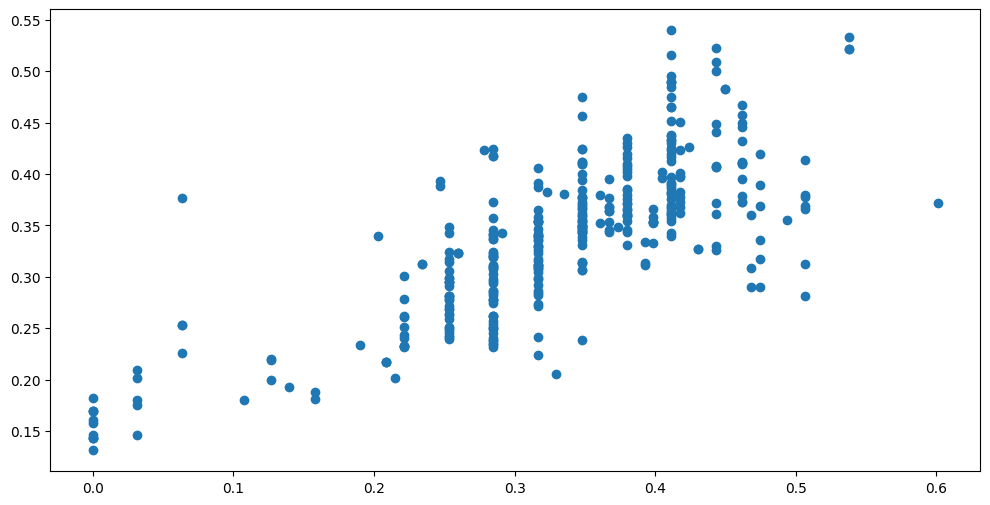

In [223]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,predictions)
plt.show()

In [224]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.04935831235473789
MSE: 0.00476387878414796
RMSE: 0.0690208576022347


In [225]:
from sklearn.linear_model import LinearRegression

# Creating and training model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = lm.predict(X_test)


In [226]:
ndf = [Reg_Models_Evaluation_Metrics(lm,X_train,y_train,X_test,y_test,y_pred)]

lm_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
lm_score.insert(0, 'Model', 'Linear Regression')
lm_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Linear Regression,0.587853,0.577662,0.482437,0.069021


Text(0.5, 1.0, 'Linear regression for RGB dataset')

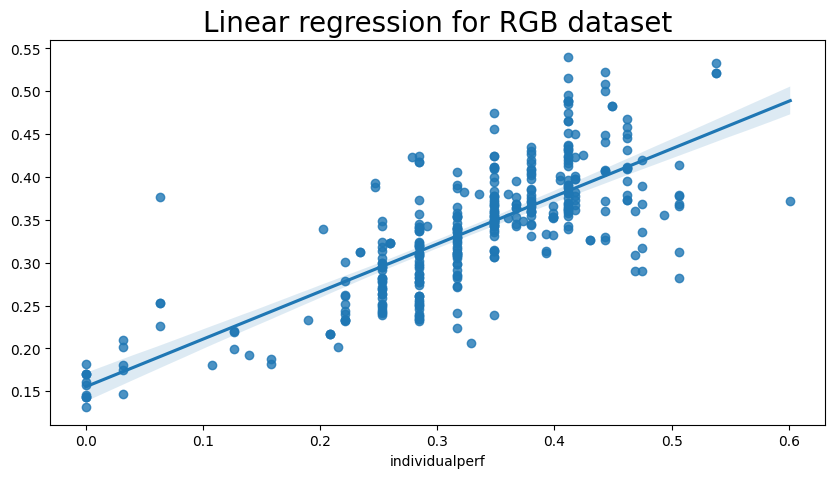

In [227]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Linear regression for RGB dataset', fontsize = 20)


##  Random Forest

In [228]:
from sklearn.ensemble import RandomForestRegressor

# Creating and training model
RandomForest_reg = RandomForestRegressor(n_estimators = 10, random_state = 0)

In [229]:
RandomForest_reg.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = RandomForest_reg.predict(X_test)

In [230]:
ndf = [Reg_Models_Evaluation_Metrics(RandomForest_reg,X_train,y_train,X_test,y_test,y_pred)]

rf_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rf_score.insert(0, 'Model', 'Random Forest')
rf_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Random Forest,0.823474,0.81911,0.764551,0.045171


## Ridge Regression

In [231]:
from sklearn.linear_model import Ridge

# Creating and training model
ridge_reg = Ridge(alpha=3, solver="cholesky")

In [232]:
ridge_reg.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = ridge_reg.predict(X_test)


In [233]:
ndf = [Reg_Models_Evaluation_Metrics(ridge_reg,X_train,y_train,X_test,y_test,y_pred)]

rr_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rr_score.insert(0, 'Model', 'Ridge Regression')
rr_score


,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Ridge Regression,0.568836,0.558176,0.482446,0.070595


## XGBoost

In [234]:
from xgboost import XGBRegressor
# create an xgboost regression model
XGBR = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.8, colsample_bytree=0.8)


In [235]:
XGBR.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = XGBR.predict(X_test)


In [236]:
ndf = [Reg_Models_Evaluation_Metrics(XGBR,X_train,y_train,X_test,y_test,y_pred)]

XGBR_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
XGBR_score.insert(0, 'Model', 'XGBoost')
XGBR_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,XGBoost,0.847903,0.844142,0.828151,0.041929


In [237]:
predictions = pd.concat([rr_score, XGBR_score, lm_score,rf_score], ignore_index=True, sort=False)
predictions

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Ridge Regression,0.568836,0.558176,0.482446,0.070595
1,XGBoost,0.847903,0.844142,0.828151,0.041929
2,Linear Regression,0.587853,0.577662,0.482437,0.069021
3,Random Forest,0.823474,0.819110,0.764551,0.045171


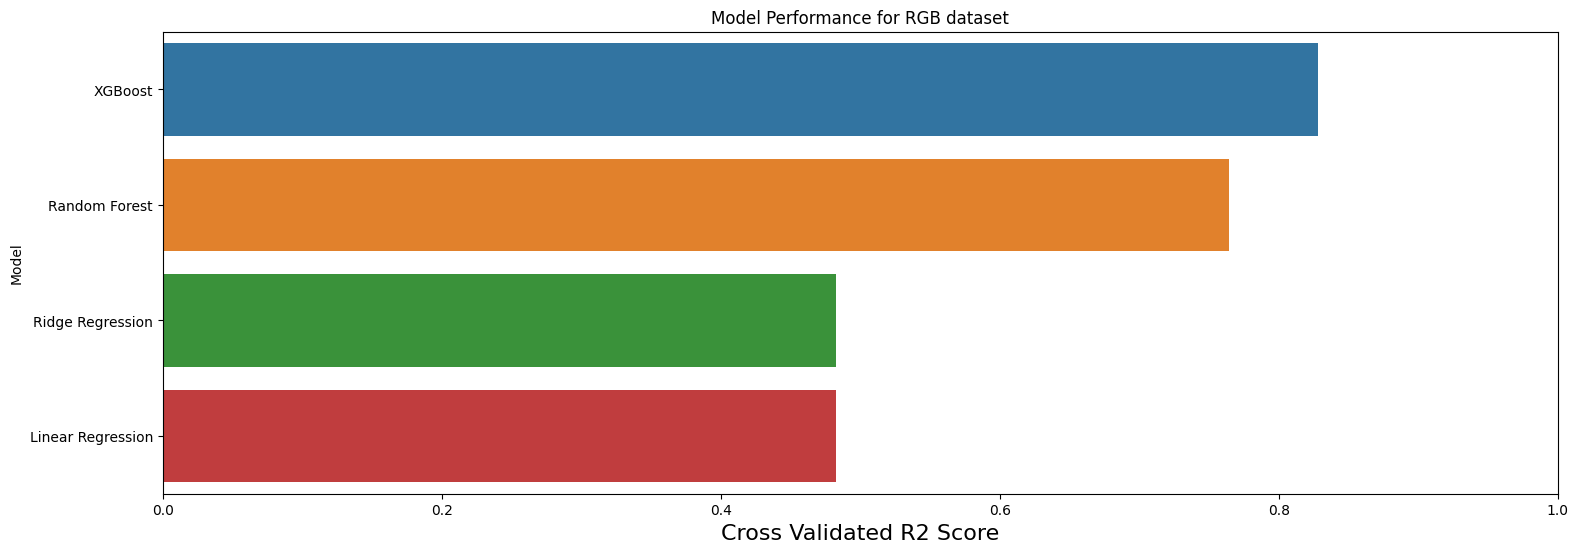

In [238]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predictions.sort_values(by=['Cross Validated R2 Score'], ascending=False, inplace=True)

sns.barplot(x='Cross Validated R2 Score', y='Model', data = predictions, ax = axe)
axe.set_xlabel('Cross Validated R2 Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)

axe.set(title='Model Performance for RGB dataset')

plt.show()

## Feature scaling and Improving Model Performance

In [239]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

    return df


In [240]:
columns = ['id', 'company id', 'job', 'department', 'mbti', 'predictor1',
       'predictor2', 'predictor3', 'predictor4', 'ctar', 'aggregatetotpred',
       'decisionstd2', 'individualperf', 'gender', 'age', 'tenure', 'degree']

In [241]:
df_cleaned.columns

Index(['predictor1', 'predictor2', 'predictor3', 'predictor4', 'ctar',
       'individualperf', 'age', 'tenure', 'gender_M',
       'decisionstd2_Not Hired'],
      dtype='object')

In [242]:
df_cleaned.head()

,predictor1,predictor2,predictor3,predictor4,ctar,individualperf,age,tenure,gender_M,decisionstd2_Not Hired
0,0.673684,0.598802,0.773333,0.666667,0.600,0.436709,0.394737,0.15,0.0,0.0
2,0.757895,0.760479,0.720000,0.606667,0.664,0.462025,0.368421,0.00,1.0,0.0
3,0.800000,0.299401,0.440000,0.166667,0.536,0.221519,0.105263,0.00,1.0,1.0
4,0.684211,0.502994,0.553333,0.440000,0.664,0.348101,0.000000,0.00,0.0,1.0
5,0.810526,0.359281,0.500000,0.440000,0.464,0.284810,0.315789,0.00,0.0,1.0


## Comparing different models

## Linear Regression


In [243]:
from sklearn.linear_model import LinearRegression

# Creating and training model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = lm.predict(X_test)

In [244]:
ndf = [Reg_Models_Evaluation_Metrics(lm,X_train,y_train,X_test,y_test,y_pred)]

lm_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
lm_score.insert(0, 'Model', 'Linear Regression')
lm_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Linear Regression,0.587853,0.577662,0.482437,0.069021


Text(0.5, 1.0, 'Linear regression for RGB dataset')

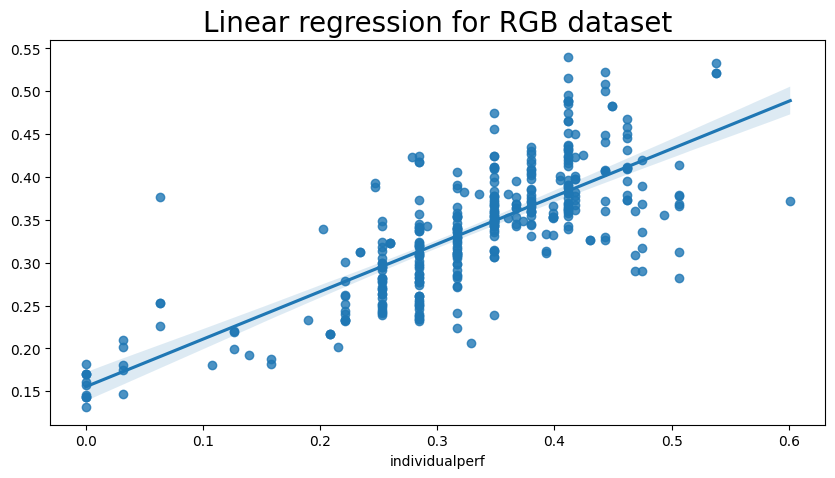

In [245]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Linear regression for RGB dataset', fontsize = 20)

## Random Forrest

In [246]:
from sklearn.ensemble import RandomForestRegressor

# Creating and training model
RandomForest_reg = RandomForestRegressor(n_estimators = 10, random_state = 0)

In [247]:
RandomForest_reg.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = RandomForest_reg.predict(X_test)

In [248]:
ndf = [Reg_Models_Evaluation_Metrics(RandomForest_reg,X_train,y_train,X_test,y_test,y_pred)]

rf_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rf_score.insert(0, 'Model', 'Random Forest')
rf_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Random Forest,0.823474,0.81911,0.764551,0.045171


## Ridge Regression

In [249]:
from sklearn.linear_model import Ridge

# Creating and training model
ridge_reg = Ridge(alpha=3, solver="cholesky")

In [250]:
ridge_reg.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = ridge_reg.predict(X_test)

In [251]:
ndf = [Reg_Models_Evaluation_Metrics(ridge_reg,X_train,y_train,X_test,y_test,y_pred)]

rr_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rr_score.insert(0, 'Model', 'Ridge Regression')
rr_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Ridge Regression,0.568836,0.558176,0.482446,0.070595


## XGBoost

In [252]:
from xgboost import XGBRegressor
# create an xgboost regression model
XGBR = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.8, colsample_bytree=0.8)

In [253]:
XGBR.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = XGBR.predict(X_test)


In [254]:
ndf = [Reg_Models_Evaluation_Metrics(XGBR,X_train,y_train,X_test,y_test,y_pred)]

XGBR_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
XGBR_score.insert(0, 'Model', 'XGBoost')
XGBR_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,XGBoost,0.847903,0.844142,0.828151,0.041929


## Recursive Feature Elimination (RFE)

In [255]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# create pipeline
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=2000)
model = RandomForestRegressor()
rf_pipeline = Pipeline(steps=[('s',rfe),('m',model)])


In [256]:
rf_pipeline.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = rf_pipeline.predict(X_test)

In [257]:
ndf = [Reg_Models_Evaluation_Metrics(rf_pipeline,X_train,y_train,X_test,y_test,y_pred)]

rfe_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rfe_score.insert(0, 'Model', 'Random Forest with RFE')
rfe_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Random Forest with RFE,0.82495,0.820622,0.796541,0.044982


##  Final Model Evaluation

In [258]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error, r2_score
# import pandas as pd

# # Load your dataset and split into features (X) and target (y)

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Feature Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Hyperparameter tuning using GridSearchCV

# # Random Forest
# rf_params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# rf_model = RandomForestRegressor(random_state=42)
# rf_grid_search = GridSearchCV(rf_model, rf_params, scoring='neg_mean_squared_error', cv=5)
# rf_grid_search.fit(X_train_scaled, y_train)
# best_rf_model = rf_grid_search.best_estimator_

# # Gradient Boosting
# gb_params = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# gb_model = GradientBoostingRegressor(random_state=42)
# gb_grid_search = GridSearchCV(gb_model, gb_params, scoring='neg_mean_squared_error', cv=5)
# gb_grid_search.fit(X_train_scaled, y_train)
# best_gb_model = gb_grid_search.best_estimator_

# # Support Vector Regression
# svr_params = {
#     'C': [0.1, 1, 10],
#     'epsilon': [0.01, 0.1, 0.2],
#     'kernel': ['linear', 'rbf']
# }
# svr_model = SVR()
# svr_grid_search = GridSearchCV(svr_model, svr_params, scoring='neg_mean_squared_error', cv=5)
# svr_grid_search.fit(X_train_scaled, y_train)
# best_svr_model = svr_grid_search.best_estimator_

# # Evaluate Models and compare them

# # Store the best models in a list
# models = [best_rf_model, best_gb_model, best_svr_model]
# model_names = ['Random Forest', 'Gradient Boosting', 'Support Vector Regression']
# results = []

# for model, name in zip(models, model_names):
#     y_pred = model.predict(X_test_scaled)
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = mse ** 0.5
#     r2 = r2_score(y_test, y_pred)
#     results.append((name, mse, rmse, r2))

# # Convert the results to a DataFrame
# results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE', 'R-squared'])
# print(results_df)


In [259]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_squared_error, r2_score
# import xgboost as xgb
# from sklearn.ensemble import StackingRegressor
# import pandas as pd

# # Load your dataset and split into features (X) and target (y)
# # ...

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Feature Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Assuming you've imported the necessary libraries and loaded the data

# # Ensemble of Models
# ensemble_predictions = (best_rf_model.predict(X_test_scaled) +
#                         best_gb_model.predict(X_test_scaled) +
#                         best_svr_model.predict(X_test_scaled)) / 3


# # Feature Engineering
# poly = PolynomialFeatures(degree=2)  # You can experiment with different degrees
# X_train_poly = poly.fit_transform(X_train_scaled)
# X_test_poly = poly.transform(X_test_scaled)

# # Regularization with Polynomial Features
# ridge_model = Ridge(alpha=1.0)
# ridge_model.fit(X_train_poly, y_train)
# ridge_predictions = ridge_model.predict(X_test_poly)

# # Increasing Model Complexity
# best_rf_model_complex = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
# best_rf_model_complex.fit(X_train_scaled, y_train)
# rf_complex_predictions = best_rf_model_complex.predict(X_test_scaled)

# # XGBoost with Hyperparameter Tuning
# xgb_params = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5]
# }
# xgb_model = xgb.XGBRegressor(random_state=42)
# xgb_grid_search = GridSearchCV(xgb_model, xgb_params, scoring='neg_mean_squared_error', cv=5)
# xgb_grid_search.fit(X_train_scaled, y_train)
# best_xgb_model = xgb_grid_search.best_estimator_
# xgb_predictions = best_xgb_model.predict(X_test_scaled)

# # Stacking of Models
# estimators = [('rf', best_rf_model), ('gb', best_gb_model), ('svr', best_svr_model)]
# stacked_model = StackingRegressor(estimators=estimators, final_estimator=best_rf_model)
# stacked_model.fit(X_train_scaled, y_train)
# stacked_predictions = stacked_model.predict(X_test_scaled)

# # Evaluate Models and compare their performance
# models = [ensemble_predictions, ridge_predictions, rf_complex_predictions, xgb_predictions, stacked_predictions]
# model_names = ['Ensemble', 'Ridge', 'Complex RF', 'XGBoost', 'Stacked',]
# results = []

# for model, name in zip(models, model_names):
#     mse = mean_squared_error(y_test, model)
#     rmse = mse ** 0.5
#     r2 = r2_score(y_test, model)
#     results.append((name, mse, rmse, r2))

# results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE', 'R-squared'])
# print(results_df)


In [176]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pandas as pd

# Load your dataset and split into features (X) and target (y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV

# Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_params, scoring='neg_mean_squared_error', cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
best_rf_model = rf_grid_search.best_estimator_

# Gradient Boosting
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gb_model = GradientBoostingRegressor(random_state=42)
gb_grid_search = GridSearchCV(gb_model, gb_params, scoring='neg_mean_squared_error', cv=5)
gb_grid_search.fit(X_train_scaled, y_train)
best_gb_model = gb_grid_search.best_estimator_

# Support Vector Regression
svr_params = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf']
}
svr_model = SVR()
svr_grid_search = GridSearchCV(svr_model, svr_params, scoring='neg_mean_squared_error', cv=5)
svr_grid_search.fit(X_train_scaled, y_train)
best_svr_model = svr_grid_search.best_estimator_

# Evaluate Models and compare them
models = [best_rf_model, best_gb_model, best_svr_model]
model_names = ['Random Forest', 'Gradient Boosting', 'Support Vector Regression']
results = []

for model, name in zip(models, model_names):
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, rmse, r2))

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE', 'R-squared'])
print("Results for Hyperparameter Tuning:")
print(results_df)



# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assuming you've imported the necessary libraries and loaded the data

# Ensemble of Models
ensemble_predictions = (best_rf_model.predict(X_test_scaled) +
                        best_gb_model.predict(X_test_scaled) +
                        best_svr_model.predict(X_test_scaled)) / 3

# Feature Engineering
poly = PolynomialFeatures(degree=2)  # You can experiment with different degrees
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Regularization with Polynomial Features
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_poly, y_train)
ridge_predictions = ridge_model.predict(X_test_poly)

# Increasing Model Complexity
best_rf_model_complex = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
best_rf_model_complex.fit(X_train_scaled, y_train)
rf_complex_predictions = best_rf_model_complex.predict(X_test_scaled)

# XGBoost with Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(xgb_model, xgb_params, scoring='neg_mean_squared_error', cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
xgb_predictions = best_xgb_model.predict(X_test_scaled)

# Stacking of Models
estimators = [('rf', best_rf_model), ('gb', best_gb_model), ('svr', best_svr_model)]
stacked_model = StackingRegressor(estimators=estimators, final_estimator=best_rf_model)
stacked_model.fit(X_train_scaled, y_train)
stacked_predictions = stacked_model.predict(X_test_scaled)

# Evaluate Models and compare their performance
models = [ensemble_predictions, ridge_predictions, rf_complex_predictions, xgb_predictions, stacked_predictions]
model_names = ['Ensemble', 'Ridge', 'Complex RF', 'XGBoost', 'Stacked']
results = []

for model, name in zip(models, model_names):
    mse = mean_squared_error(y_test, model)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, model)
    results.append((name, mse, rmse, r2))

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE', 'R-squared'])
print("Results for Stacking and Advanced Models:")
print(results_df)


Results for Hyperparameter Tuning:
                       Model       MSE      RMSE  R-squared
0              Random Forest  0.001282  0.035806   0.893946
1          Gradient Boosting  0.001191  0.034512   0.901472
2  Support Vector Regression  0.002564  0.050636   0.787897
Results for Stacking and Advanced Models:
        Model       MSE      RMSE  R-squared
0    Ensemble  0.001332  0.036502   0.889781
1       Ridge  0.003414  0.058431   0.717576
2  Complex RF  0.001305  0.036127   0.892037
3     XGBoost  0.001370  0.037014   0.886666
4     Stacked  0.001310  0.036198   0.891609


In [260]:
results_df.head()

,Model,MSE,RMSE,R-squared
2,Complex RF,0.001305,0.036127,0.892037
4,Stacked,0.001310,0.036198,0.891609
0,Ensemble,0.001332,0.036502,0.889781
3,XGBoost,0.001370,0.037014,0.886666
1,Ridge,0.003414,0.058431,0.717576


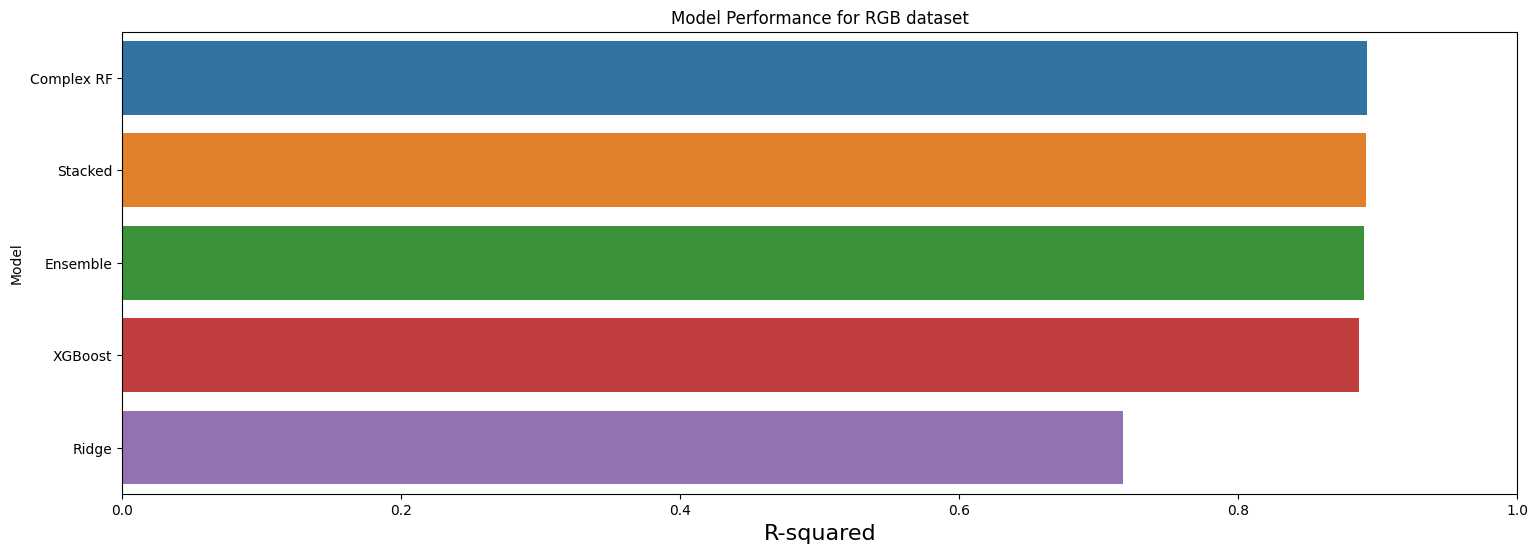

In [261]:
f, axe = plt.subplots(1,1, figsize=(18,6))

results_df.sort_values(by=['R-squared'], ascending=False, inplace=True)

sns.barplot(x='R-squared', y='Model', data = results_df, ax = axe)
axe.set_xlabel('R-squared', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)

axe.set(title='Model Performance for RGB dataset')

plt.show()